In [16]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

In [17]:
sys.path.append('../../../satmetrics')
sys.path.append('../../../reca-streaks')

import line_detection_updated as ld
from photutils.background import Background2D

import image_rotation as ir
import streak_photometry

import pixelplot

In [18]:
root = "/home/plazas/DATA/DECam-sample-streak-images/"
fits_files = {
    (1033925, 17): root + "2f8ef733fa7c2affc9937357519e5148/contents",
    (1061946, 18): root + "f9356eeb22aa0efaedbf094f24c07f46/contents",
    (1049047, 18): root + "637aa3fb7d37a2ec076c8d945eab6c41/contents",
    (1134933, 5):  root + "1c1eebc352ea7660ff514d1b5df563b5/contents",
    (1138498, 23): root + "bb528e73d3221682c2d7d36246577ce5/contents",
    (1103448, 26): root + "c0bc6f8bf8d47c08c9bd40902ec4dad5/contents",
    (1072590, 5):  root + "5b514488fd31468a5c4aa3192c597a30/contents",
    (1161471, 9):  root + "3452b0b8f0665cd55acf1c0a0eb2e859/contents",
    (1129877, 51): root + "73234656cc02496d9a023dd0d117354a/contents",
    (1126795, 39): root + "29d9a03051904435919ec43194f969cd/contents",
    (984831, 7):   root + "90a49bfcacf8573b76b5477722e183f7/contents",
    (984831, 28):  root + "cc27b87c5865fd628e3d1aff2b57e330/contents",
    (1054799, 38): root + "a89a7ddeacf3633f83d382bfddb97ee5/contents",
    (1074544, 28): root + "426fe2b46afc5b5cea29ae864d11e73a/contents",
    (1074544, 17): root + "04dd6929bc54810daa7624bff154b15c/contents",
    (1189811, 26): root + "f0d3c52b3544829a2ff771baf77d4e00/contents",
    (1074073, 32): root + "f0a9671bb09939f1a141d87010d45101/contents",
    (1166793, 45): root + "34a0b1e227d593e1005691726b8d262b/contents",
    (1125268, 21): root + "ec65024afa8ab1486bf8e0f1fd676964/contents",
    (1125268, 14): root + "bf34a85f1c84bdaa26b0fcd378e296d3/contents",
}

In [19]:
def detect_lines_hough(image, threshold=0.075, flux_prop_thresholds=[0.1,0.2,0.3,1], 
                       blur_kernel_sizes=[3,5,9,11], brightness_cuts=(2,2), thresholding_cut=0.5 ,**kwargs):

    """
    Applies Hough Transform line detection on a DECam image using the custom satmetrics module.

    Parameters:
        image (ndarray): 2D image array.
        **kwargs: Optional keyword arguments to pass into the LineDetection object (e.g. thresholds).
    """
    lineDetector = ld.LineDetection(image)
    lineDetector.threshold = threshold
    lineDetector.flux_prop_thresholds = flux_prop_thresholds
    lineDetector.blur_kernel_sizes = blur_kernel_sizes
    lineDetector.brightness_cuts = brightness_cuts
    lineDetector.thresholding_cut = thresholding_cut
    # Detector instance
   # lineDetector = ld.LineDetection(image)
    #lineDetector.threshold = 0.012 it could break the threshold
    for key, value in kwargs.items():
        setattr(lineDetector, key, value)

    # Hough transform
    detections = lineDetector.hough_transformation()
    return detections

In [20]:
def rotate_streak_horizontal(image, lines):
    """
    Rotates the image so that the main detected streak (line) is horizontal.
    
    """
    if lines is None or len(lines) == 0:
        raise ValueError("No lines detected to use for rotation.")
    
    line = lines[0]
    coords = [[line[0], line[1]], [line[2], line[3]]]
    angle = ir.determine_rotation_angle(coords)
    rotated_image = ir.rotate_image(image, angle, coords)
    
    return rotated_image, coords, angle

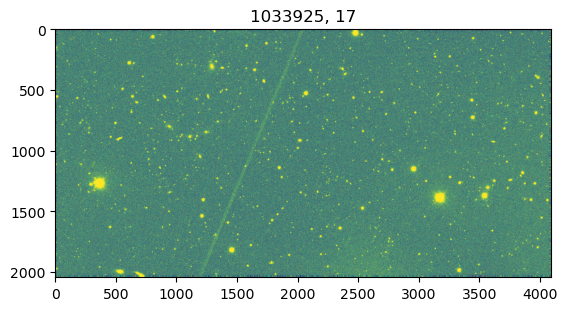

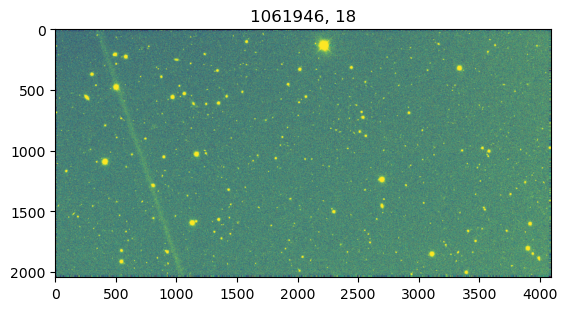

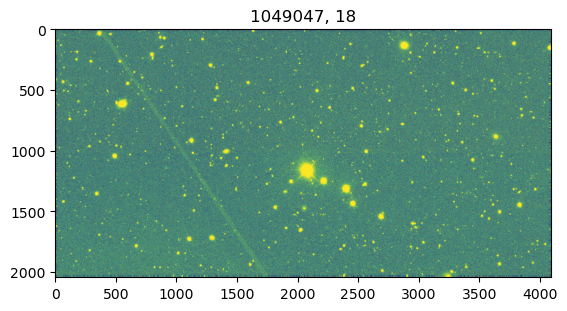

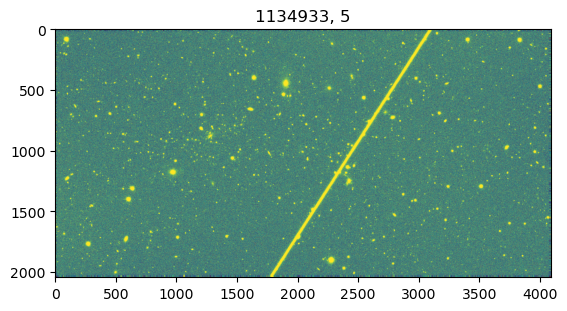

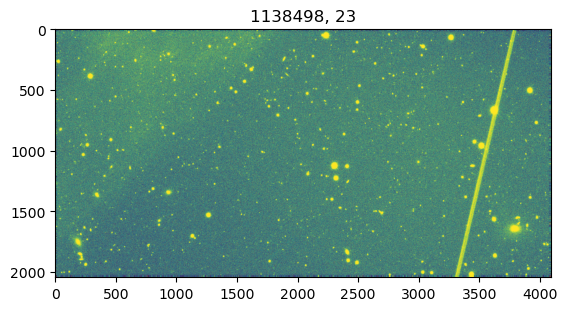

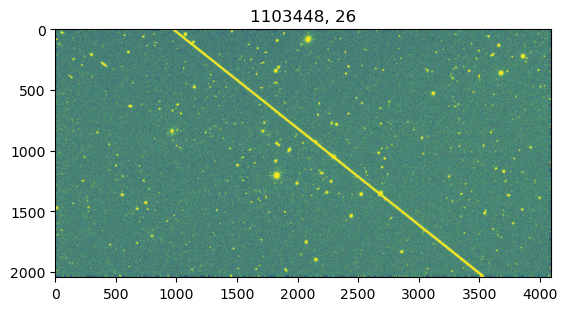

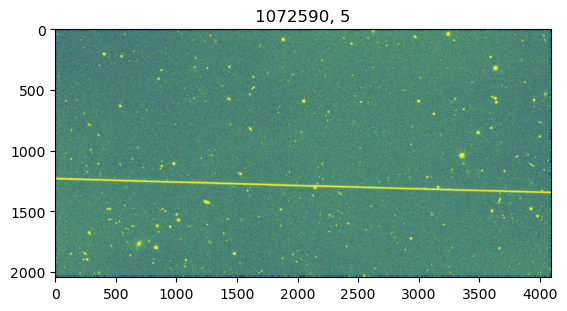

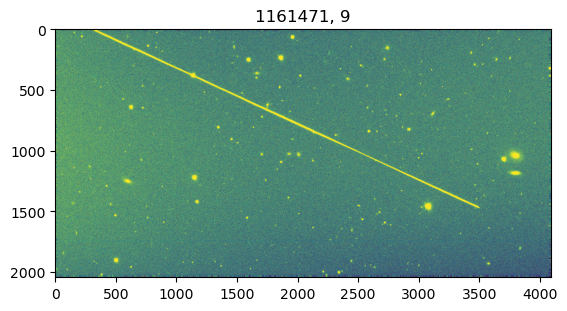

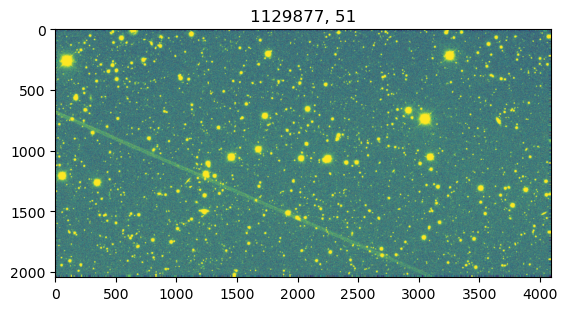

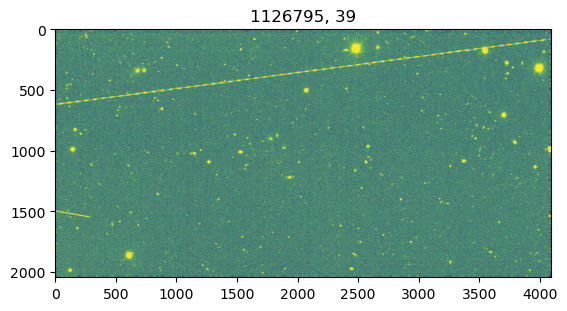

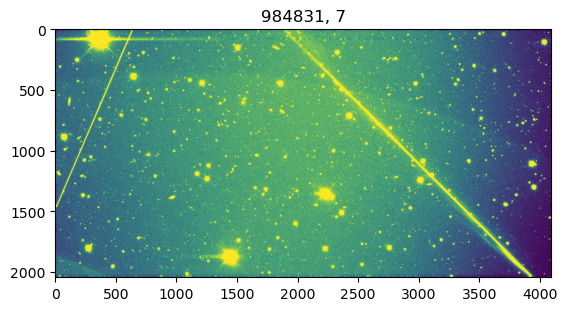

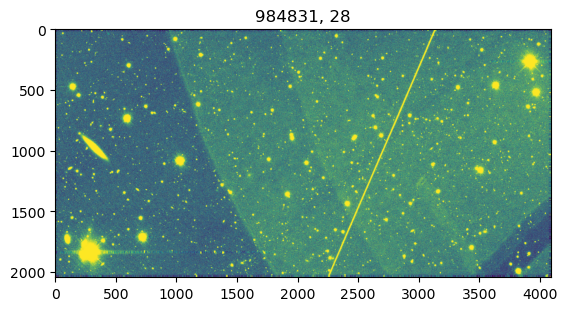

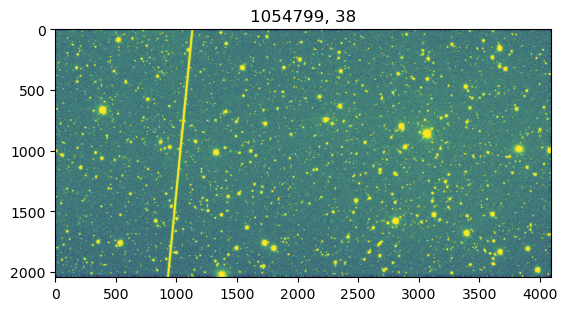

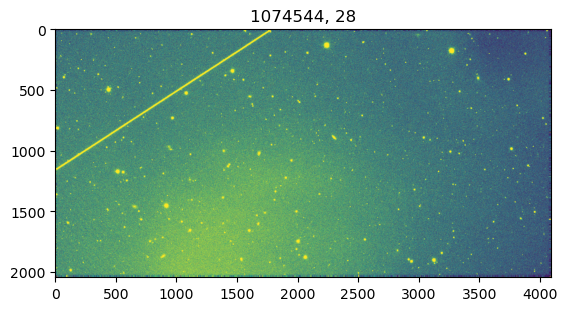

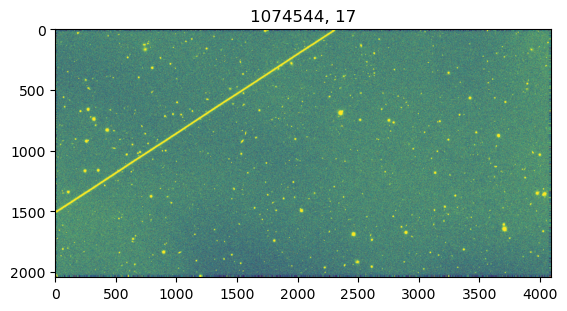

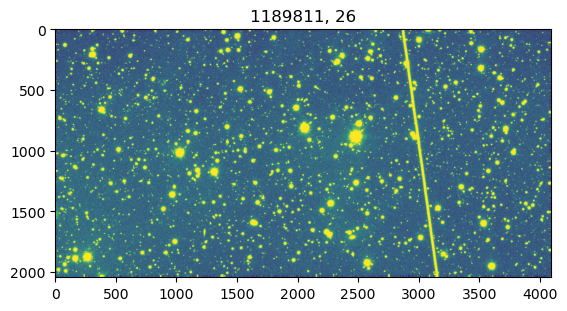

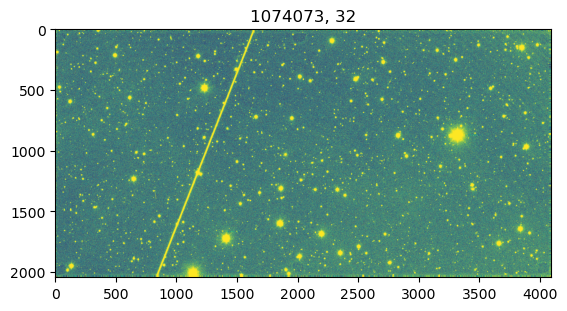

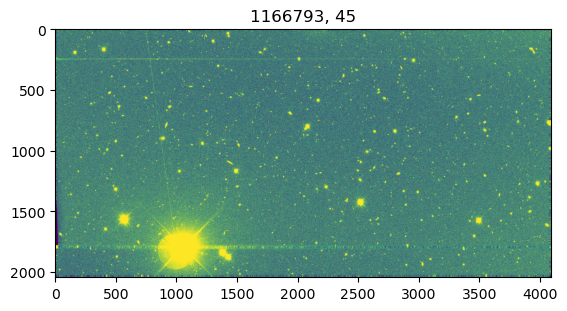

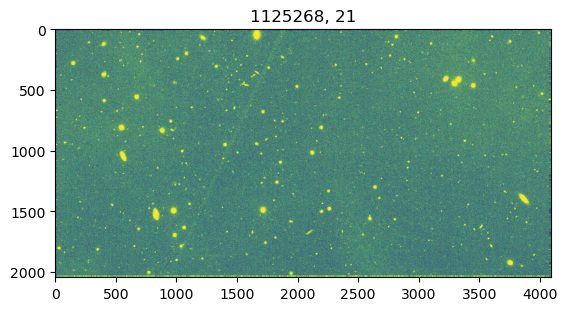

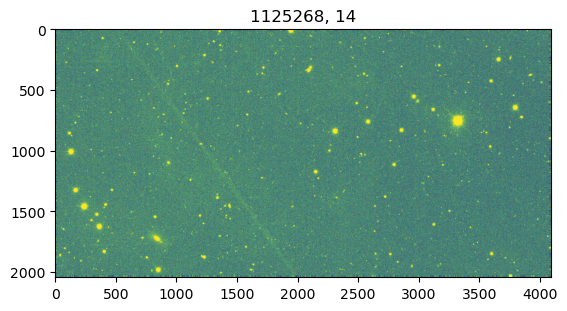

In [21]:
for key in fits_files: 
    expnum, detector = key
    file_name = fits_files[key]
    hdulist = fits.open(file_name)
    image_data = hdulist[1].data
    fig = plt.figure()
    plt.imshow(image_data.T, vmin = np.percentile(image_data,5),
          vmax = np.percentile(image_data, 95))
    plt.title(f"{expnum}, {detector}")

Saved: streak_mosaic_table.pdf


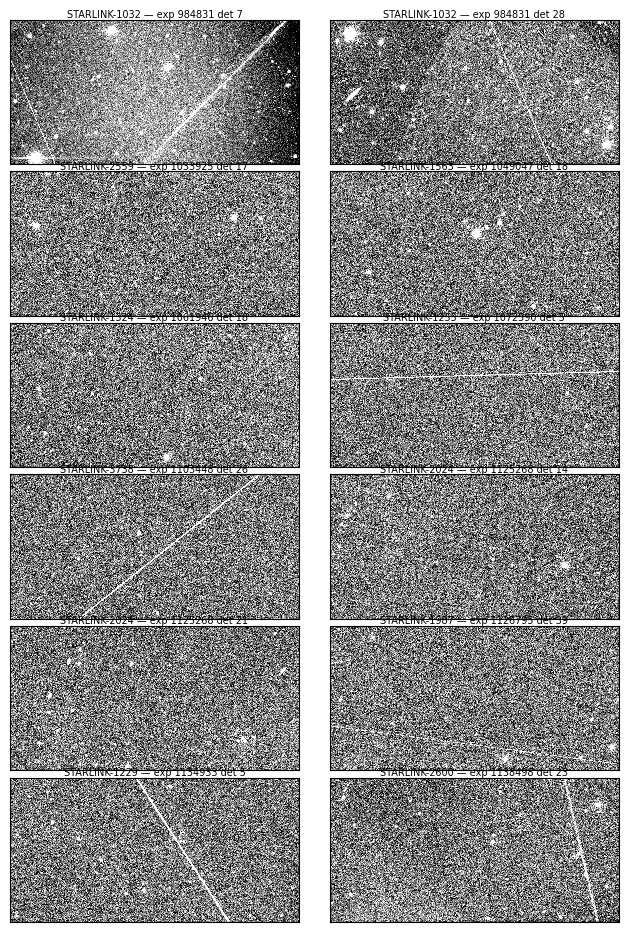

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# === Only the satellites included in your LaTeX table ===
starlink_name = {
    1134933: "STARLINK-1229",
    1138498: "STARLINK-2600",
    1072590: "STARLINK-1255",
    1126795: "STARLINK-1987",
    984831:  "STARLINK-1032",
    1125268: "STARLINK-2024",
    1103448: "STARLINK-3738",
    1033925: "STARLINK-2559",
    1061946: "STARLINK-1324",
    1049047: "STARLINK-1563",
}

# Build list of available keys from the table entries
keys = [(exp, det) for (exp, det) in fits_files.keys() if exp in starlink_name]

# Sort by exposure number (for consistent order)
keys = sorted(keys, key=lambda k: (k[0], k[1]))

# Compute grid dimensions automatically (2 columns)
ncols = 2
nrows = int(np.ceil(len(keys) / ncols))

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(6.5, 1.6 * nrows),
    constrained_layout=False
)
fig.subplots_adjust(left=0.02, right=0.98, top=0.97, bottom=0.03,
                    hspace=0.05, wspace=0.05)

# Flatten axes for simpler iteration
axes = np.atleast_1d(axes).flatten()

for i, ax in enumerate(axes):
    if i >= len(keys):
        ax.axis("off")
        continue

    expnum, det = keys[i]
    fname = fits_files[(expnum, det)]
    with fits.open(fname, memmap=True) as hdul:
        img = hdul[1].data

    vmin, vmax = np.percentile(img, (5, 95))
    ax.imshow(img.T, cmap="gray", origin="lower",
              vmin=vmin, vmax=vmax, interpolation="none", aspect="equal")
    ax.set_xticks([])
    ax.set_yticks([])

    name = starlink_name.get(expnum, f"exp {expnum}")
    ax.set_title(f"{name} — exp {expnum} det {det}",
                 fontsize=7, pad=1.5)

# Save compact PDF
pdf_out = "streak_mosaic_table.pdf"
fig.savefig(pdf_out, bbox_inches="tight")
print(f"Saved: {pdf_out}")

# Display inline in the notebook
plt.show()


In [23]:
detect_lines_thresholds = { (1103448, 26, 'thresholding_cut'): 0.03,
                            (1033925, 17, 'brightness_cuts'): (3,5),
                            (1033925, 17, 'thresholding_cut'): 0.08, 
                            (1061946, 18, 'thresholding_cut'): 0.08,
                            (1061946, 18, 'brightness_cuts'): (3,5),
                            (1049047, 18, 'brightness_cuts'): (3,5),
                            (1049047, 18, 'thresholding_cut'): 0.06,
                          }



In [48]:
for key in fits_files:
    print (" ")
    print (" ")
    print (" ")
    print (" ")
    expnum, detector = key
    if expnum != 1054799:
        continue
    file_name = fits_files[key]
    hdulist = fits.open(file_name)
    image_data = hdulist[1].data
    #try:
    print ("Trying: ", expnum, detector)
    detected_lines = detect_lines_hough(image_data,
                                        brightness_cuts= (3,5),
                                        thresholding_cut= 0.06)
    clustered_lines = ld.cluster(detected_lines["Cartesian Coordinates"],
                                     detected_lines["Lines"])
    rotated_images, best_fit_params = ir.complete_rotate_image(
                                                clustered_lines=clustered_lines,
                                                angles=detected_lines["Angles"],
                                                image=image_data,
                                                cart_coord=detected_lines['Cartesian Coordinates'])
    pixelplot.pixelplot(rotated_images[0])
    streak_photometry.streak_photometry(rotated_images[0], hdu_list = hdulist)
    streak_photometry.streak_photometry_psf_fitting(rotated_images[0],
                                                        hdu_list = hdulist)
    #except: 
    #    print ("       Failed: ", expnum, detector)

 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
Trying:  1054799 38


IndexError: list index out of range

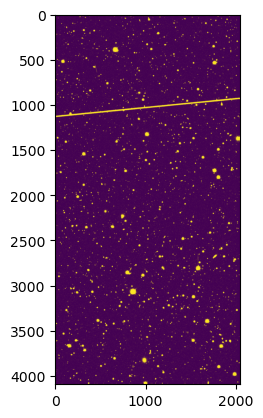

In [40]:
plt.imshow(detected_lines['Thresholded Image'])

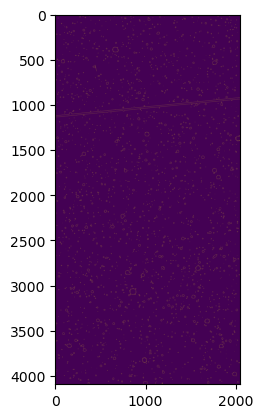

In [41]:
plt.imshow(detected_lines['Edges'])

In [42]:
clustered_lines

array([[1117.        ,    1.47480322,    0.        ],
       [1133.        ,    1.47480322,    0.        ]])

In [43]:
rotated_images

[]

In [44]:
print(detected_lines.keys())
for k, v in detected_lines.items():
    print(k, len(v))

dict_keys(['Lines', 'Angles', 'Cartesian Coordinates', 'Thresholded Image', 'Blurred Image', 'Edges'])
Lines 2
Angles 2
Cartesian Coordinates 2
Thresholded Image 4094
Blurred Image 4094
Edges 4094
